# INFO212 Assignment2 T22
*Name: Qinru Yang ID: 32022940961  
Name: Rongshen He ID: 320220940271  
Name: Qirui Zhang ID:  
Name: Wei Dou ID:*

In [1]:
# package installation
!pip install seaborn
!pip install "altair[all]"

In [2]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import altair as alt
import seaborn as sns
import warnings
from IPython.core.display import HTML
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
warnings.filterwarnings("ignore", message="FutureWarning")

## Step1: Data Collection  
- We first call the **World Bank API** to query data on GDP, unemployment rate, inflation, and other metrics for five countries, spanning nearly 40 years. We use the API because most of the existing datasets available online are not in JSON format. Since JSON data is often used for efficient front-end and back-end transmission and contains some unnecessary parameters, we decided to use the API to obtain the dataset in JSON format.   
- We constructs a URL for each country and indicator, sends a request to the World Bank API, and processes the JSON response. The data for each indicator and country is stored in a dictionary.Finally, the combined data is saved into a JSON file named "world_bank_data.json". 

In [3]:
# 定义查询的国家和指标
countries = ["CN", "BR", "JP", "CA", "NP"]
indicators = {
    "GDP": "NY.GDP.MKTP.CD",
    "Unemployment": "SL.UEM.TOTL.ZS",
    "Inflation": "FP.CPI.TOTL",
    "Tariff rate": "TM.TAX.MANF.SM.AR.ZS",
    "GDP growth": "NY.GDP.MKTP.KD.ZG"
}
years = range(1980, 2019 + 1)
base_url = "http://api.worldbank.org/v2/country/{}/indicator/{}?date={}:{}&format=json&per_page=100"

# 获取数据并合并成一个JSON文件
data = {}
for indicator_name, indicator_code in indicators.items():
    data[indicator_name] = {}
    for country in countries:
        response = requests.get(base_url.format(country, indicator_code, years[0], years[-1]))
        if response.status_code == 200:
            result = response.json()
            if len(result) > 1:
                data[indicator_name][country] = result[1]
        else:
            print(f"Error fetching data for {country} - {indicator_name}: {response.status_code}")

# 保存数据到JSON文件
with open("world_bank_data.json", "w") as f:
    json.dump(data, f, indent=4)

print("Data has been saved to world_bank_data.json")


Data has been saved to world_bank_data.json


In [4]:
with open("world_bank_data.json", "r") as f:
    data = json.load(f)

## Step2: Data Preparation  
- **Frist, we load the JSON files into Pandas DataFrames.** Because JSON data is nested and hierarchical and contains some unnecessary parameters, which can make it challenging to work with directly. 
- So we create **create_indicator_dataframe function**. It iterates through the JSON data for a specific indicator, extracting the country code, date, and corresponding indicator value for each entry. These records are then organized into a DataFrame with columns for country, date, and the specified indicator. 
- Then we create **display_dfs function**. It's used to beautify and display multiple dataframes in a single output. It utilizes the **highlight_null** parameter to highlight missing values. It employs **to_html** to print the dataframes as HTML, making the output easier to observe.

In [5]:
# 国家名称映射字典
country_names = {"CN": "China", "BR": "Brazil", "JP": "Japan", "CA": "Canada", "NP": "Nepal"}

def create_indicator_dataframe(data, indicator):
    records = [(country_names[country_code], int(entry['date']), entry['value']) for country_code, values in data[indicator].items() for entry in values]
    df = pd.DataFrame(records, columns=['country', 'date', indicator])
    df_pivot = df.pivot(index='date', columns='country', values=indicator)
    return df_pivot

# 创建GDP、Unemployment、Inflation的DataFrame
gdp_df = create_indicator_dataframe(data, "GDP")
unemployment_df = create_indicator_dataframe(data, "Unemployment")
inflation_df = create_indicator_dataframe(data, "Inflation")
tariff_df = create_indicator_dataframe(data, "Tariff rate")
gdp_growth_df = create_indicator_dataframe(data, "GDP growth")

dfs = dict(zip(["GDP DataFrame", "Unemployment DataFrame", "Inflation DataFrame", "Tariff rate DataFrame", "GDP growth DataFrame"]
               , [gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df]))
    
def display_dfs(df, title):
    df_list = {}
    for _df, _title in zip(df, title):
        df_list[_title] = _df.style.highlight_null(null_color='#B0E0E6').set_caption(_title)
    for _title, _styled_df in df_list.items():
        display(HTML(_styled_df.to_html()))


# 调用display_dfs函数来一次性输出所有DataFrame
display_dfs([gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df]
            , ["GDP DataFrame", "Unemployment DataFrame", "Inflation DataFrame", "Tariff rate DataFrame", "GDP growth DataFrame"])

C:\Users\h\AppData\Local\Temp\ipykernel_146912\350536582.py:23: FutureWarning: `null_color` is deprecated: use `color` instead
  df_list[_title] = _df.style.highlight_null(null_color='#B0E0E6').set_caption(_title)


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,274776566028.053009,306165314855.846008,1129377244854.040039,1945916583.333330
1981,nan,307246642755.859009,289576581830.448975,1245221410764.149902,2275583316.666670
1982,nan,314647807408.607971,283928672988.111023,1158731426905.850098,2395423680.228520
1983,nan,341866277182.732971,304748904221.289001,1270859919742.899902,2447174803.540510
1984,nan,356718400123.543030,313728547706.896973,1345824500836.760010,2581207387.797090
1985,nan,366186012449.651978,309835803013.586975,1427019759717.409912,2619913955.515560
1986,nan,379006836991.723999,300514204520.968994,2120083812109.909912,2850782092.693870
1987,nan,433134238310.708984,327089403146.072998,2580748422781.089844,2957255379.543150
1988,nan,509380027626.554016,407844670393.057983,3125724434400.790039,3487009748.356380


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,nan,nan,nan,nan
1981,nan,nan,nan,nan,nan
1982,nan,nan,nan,nan,nan
1983,nan,nan,nan,nan,nan
1984,nan,nan,nan,nan,nan
1985,nan,nan,nan,nan,nan
1986,nan,nan,nan,nan,nan
1987,nan,nan,nan,nan,nan
1988,nan,nan,nan,nan,nan


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,0.000000,37.807670,nan,77.162600,8.998772
1981,0.000000,42.522896,nan,80.952953,10.001672
1982,0.000000,47.102175,nan,83.171906,11.171723
1983,0.000000,49.864053,nan,84.751939,12.554473
1984,0.000000,52.010590,nan,86.668701,12.911747
1985,0.000000,54.071265,nan,88.430049,13.951483
1986,0.000000,56.339439,26.048320,88.956727,16.602119
1987,0.000000,58.793646,27.932612,89.068970,18.386901
1988,0.000002,61.161992,33.187245,89.673354,20.038597


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,nan,nan,nan,nan
1981,nan,nan,nan,nan,nan
1982,nan,nan,nan,nan,nan
1983,nan,nan,nan,nan,nan
1984,nan,nan,nan,nan,nan
1985,nan,nan,nan,nan,nan
1986,nan,nan,nan,nan,nan
1987,nan,nan,nan,nan,nan
1988,nan,nan,nan,3.960000,nan


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,9.200000,2.177199,7.834145,2.817591,-2.319394
1981,-4.250000,3.415065,5.112761,4.260624,8.341974
1982,0.830000,-3.166150,9.017114,3.279743,3.779375
1983,-2.930000,2.562254,10.770203,3.630199,-2.977406
1984,5.400000,5.898569,15.191540,4.410880,9.681130
1985,7.850000,4.737681,13.430678,5.159808,6.144905
1986,7.490000,2.121481,8.949962,3.294048,4.565651
1987,3.530000,4.072016,11.657428,4.648861,1.695618
1988,-0.060000,4.410839,11.222595,6.661637,7.696809


- We create **clear_Nan function** to clear the nan data in the dataframe. It creates a **mask** indicating the locations of NaN values, replaces them with the specified value, and then returns the mask.

In [6]:
def clear_Nan(df,value=0):
    Nan_mask = df.isna()
    df[Nan_mask] = value
    return Nan_mask

clear_Nan(gdp_df, 0)
clear_Nan(unemployment_df, 0)
clear_Nan(inflation_df, 0)
clear_Nan(tariff_df, 0)
clear_Nan(gdp_growth_df, 0)
print()

## Step3: Data Analysis
- We perform exploratory data analysis (EDA) to understand the datasets. 
- The purpose of this **Exploratory Data Analysis (EDA)** code is to summarize and understand the relationships between different economic indicators for various countries over a specified period. By calculating descriptive statistics and correlation matrices, we aim to identify patterns, trends, and potential relationships among these indicators across different countries.

- To get a summary of key statistics (mean, standard deviation, min, max) for each indicator DataFrame.We directly call the pandas function **describe()** to show the data distribution of each indicator, it could tell us the important features of data like mean and std. 

In [7]:
dfs_summary = {}

for (name,df) in dfs.items():
    dfs_summary[name] = df.describe()
display_dfs(dfs_summary.values(), dfs_summary.keys())

C:\Users\h\AppData\Local\Temp\ipykernel_146912\350536582.py:23: FutureWarning: `null_color` is deprecated: use `color` instead
  df_list[_title] = _df.style.highlight_null(null_color='#B0E0E6').set_caption(_title)


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,950475755554.892212,954144577189.869385,3534644162818.859375,4070476970661.221680,10071952382.136709
std,840043881263.569336,540811136966.942993,4405534148271.839844,1469988285577.757080,9437549106.365099
min,0.000000,274776566028.053009,283928672988.111023,1129377244854.040039,1945916583.333330
25%,403150971309.518005,576093169615.360840,411992751614.119263,3170859601098.084961,3515671811.831993
50%,662368828394.916992,708696994313.244995,1152671067253.620117,4558345699696.529297,5263947296.005489
75%,1720814683327.167480,1534243479110.984863,5348066279953.450195,5000017567691.787109,13641903206.675951
max,2616156223977.470215,1846597421834.979980,14279968506242.800781,6272362996105.030273,34186180695.996899


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,6.639525,5.682500,2.864750,2.771250,7.727600
std,4.475284,3.783724,1.907509,1.924971,4.819939
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.805000,6.985000,3.255000,3.260000,10.655000
75%,10.250000,7.790000,4.535000,4.382500,10.666250
max,12.790000,11.380000,4.720000,5.390000,10.682000


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,58.253041,81.457677,69.369470,97.541729,67.052250
std,54.751145,21.642812,39.709831,7.310468,52.658025
min,0.000000,37.807670,0.000000,77.162600,8.998772
25%,0.000677,66.512235,40.140815,93.828495,23.159284
50%,50.803137,80.806382,81.261160,100.681781,55.079209
75%,96.402236,98.690612,98.224998,102.253180,93.601846
max,167.397860,116.757298,125.083154,105.484268,188.729977


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,13.150750,3.071500,8.843750,2.098250,7.331000
std,9.427750,2.936415,10.350033,1.175759,7.428742
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.590000,0.000000,0.000000,2.030000,0.000000
50%,14.010000,2.920000,7.955000,2.395000,11.160000
75%,15.342500,4.415000,11.045000,2.787500,12.702500
max,44.420000,10.640000,40.750000,3.960000,23.230000


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,2.403548,2.396318,9.440715,1.870137,4.503492
std,3.330191,1.959001,2.735430,2.265391,2.640425
min,-4.350000,-3.166150,3.920251,-5.693236,-2.977406
25%,0.494951,1.793704,7.740025,0.579069,3.476499
50%,2.606843,2.647825,9.249783,1.617979,4.549365
75%,4.522135,3.261607,11.021114,3.351375,6.114706
max,9.200000,5.898569,15.191540,6.661637,9.681130


- Inorder to get the correlations between indicators for every country, we iterate over all the dataframes to get new dataframe we needed. We then use **corr method** to calculate the correlation matrix for each country-specific DataFrame.

In [8]:
def create_country_dataframe(dfs, country):
    out_df = pd.DataFrame()
    indicators = dfs.keys()

    for df in dfs.values():
        out_df = pd.concat((out_df,df[country]),axis=1)  # get a dataframe that contains all the indicators
    out_df.columns = indicators
    return out_df

country_dfs = {}
for country in country_names.values(): # iterate throuth all the countries to get dataframes
    country_dfs[country] = create_country_dataframe(dfs,country)
    
df_corrs = {}

for (name,df) in country_dfs.items(): # iterate throuth all the countries to compute correlation matrix
    df_corr = df.corr() # compute correlation matrix
    df_corrs[name] = df_corr

# display all the correlation matrixs
display_dfs(df_corrs.values(), df_corrs.keys())

C:\Users\h\AppData\Local\Temp\ipykernel_146912\350536582.py:23: FutureWarning: `null_color` is deprecated: use `color` instead
  df_list[_title] = _df.style.highlight_null(null_color='#B0E0E6').set_caption(_title)


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.629564,0.760270,-0.120913,-0.388229
Unemployment DataFrame,0.629564,1.000000,0.935987,0.317299,-0.049736
Inflation DataFrame,0.760270,0.935987,1.000000,0.215172,-0.251328
Tariff rate DataFrame,-0.120913,0.317299,0.215172,1.000000,0.365621
GDP growth DataFrame,-0.388229,-0.049736,-0.251328,0.365621,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.599195,0.892347,0.247935,-0.067212
Unemployment DataFrame,0.599195,1.000000,0.755121,0.320915,-0.047503
Inflation DataFrame,0.892347,0.755121,1.000000,0.130586,-0.131907
Tariff rate DataFrame,0.247935,0.320915,0.130586,1.000000,-0.206189
GDP growth DataFrame,-0.067212,-0.047503,-0.131907,-0.206189,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.835356,0.897638,0.680794,-0.563491
Unemployment DataFrame,0.835356,1.000000,0.803835,0.495917,-0.658705
Inflation DataFrame,0.897638,0.803835,1.000000,0.653784,-0.611186
Tariff rate DataFrame,0.680794,0.495917,0.653784,1.000000,-0.250452
GDP growth DataFrame,-0.563491,-0.658705,-0.611186,-0.250452,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.409645,0.936333,0.093660,-0.143342
Unemployment DataFrame,0.409645,1.000000,0.595995,0.471881,-0.102753
Inflation DataFrame,0.936333,0.595995,1.000000,0.246614,-0.105046
Tariff rate DataFrame,0.093660,0.471881,0.246614,1.000000,0.082769
GDP growth DataFrame,-0.143342,-0.102753,-0.105046,0.082769,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.481428,0.977601,0.371648,0.178452
Unemployment DataFrame,0.481428,1.000000,0.611616,0.616641,0.084457
Inflation DataFrame,0.977601,0.611616,1.000000,0.469178,0.146675
Tariff rate DataFrame,0.371648,0.616641,0.469178,1.000000,-0.145362
GDP growth DataFrame,0.178452,0.084457,0.146675,-0.145362,1.000000


## Step4: Data Visualization 

- Create visualizations to represent the trends and patterns discovered 
during EDA. 
- Use line plots, bar charts, and scatter plots to compare different 
economic indicators across countries. 
- Employ Seaborn’s advanced features like facet grids or pair plots to 
visualize multi-dimensional data.

In [9]:
df = gdp_df.reset_index()
bar = alt.Chart(df).transform_fold(
    ['China','Japan','Brazil','Canada','Nepal',],# rearrange the datas to beautify the chart
    as_=['Country', 'GDP']
).mark_bar(
    opacity=0.7,
    binSpacing=0
).encode(
    x=alt.X('date:O', title='Year'),  # Ordinal for discrete years
    y=alt.Y('GDP:Q', title='GDP').stack(None),
    color=alt.Color('Country:N', title='Country')
).interactive()

# calculate the average GDP of all the countrys the indicate the thrend
mean_df = df.set_index('date').mean(axis=1).reset_index()
mean_df.columns = ['date', 'Mean GDP growth']

mean_line = alt.Chart(mean_df).mark_line(color='red').encode(
    x=alt.X('date:O'),
    y=alt.Y('Mean GDP growth:Q')
)
(bar + mean_line).properties(
    title='GDP Growth by Country and Year'
)

alt.LayerChart(...)

The generated chart would be like this (if you want to validate it your self just run the cell)
![barchart](http://8.222.204.221/INFO212/HW2/barchart.png)

- Explore treads of different indicators across countries

In [10]:
import altair as alt
import pandas as pd

def draw_line_chart(name, df):
    df = df.reset_index()
    long_df = pd.melt(df, id_vars=['date'], var_name='Country', value_name=f'{name}')
    chart = alt.Chart(long_df).mark_line(point={'size': 10}).encode(
        x='date:O',  # 'date:T' if the year is in datetime format
        y=f'{name}:Q',
        color='Country:N',
        tooltip=['Country', 'date', f'{name}']
    ).properties(
        title=f'{name} of Five Countries',
        width=350,  
        height=300 
    ).interactive() # set interactive chart
    return chart

charts = [draw_line_chart(name, df) for name, df in dfs.items()]

# organize the charts into two parts, setting two charts in every part. 
grid = alt.vconcat(
    alt.hconcat(*charts[:2]),
    alt.hconcat(*charts[2:4])
).configure_axis(
    labelFontSize=6,  # 设置坐标轴标签字体大小为10
    titleFontSize=10  # 设置坐标轴标题字体大小为12
)


grid.display()

alt.VConcatChart(...)

In [11]:
# 对于这些折线图我们可以得出以下结论：
# 1. 对于失业率来说我们可以看到在1999-2004年间各国的失业率都比较高，而随后大部分国家的失业率都在稳步下降
# 2. 对于通胀率，我们可以发现各国的通胀率从1980年开始就在不断地上升，而其中尼泊尔的通胀率上升最为严重，这可能是由于国内动荡以及外部环境的不稳定
# 3. 我们可以发现各国的关税率在1980年以来都在逐步下降，这可以说明世界贸易的不断进展与开放
# 4. GDP增长率反应了一个国家的发展速度，我们可以发现各国的GDP都在某一均值附近来回波动，其中，中国的GDP增速尤为明显

Explore relations between indicators

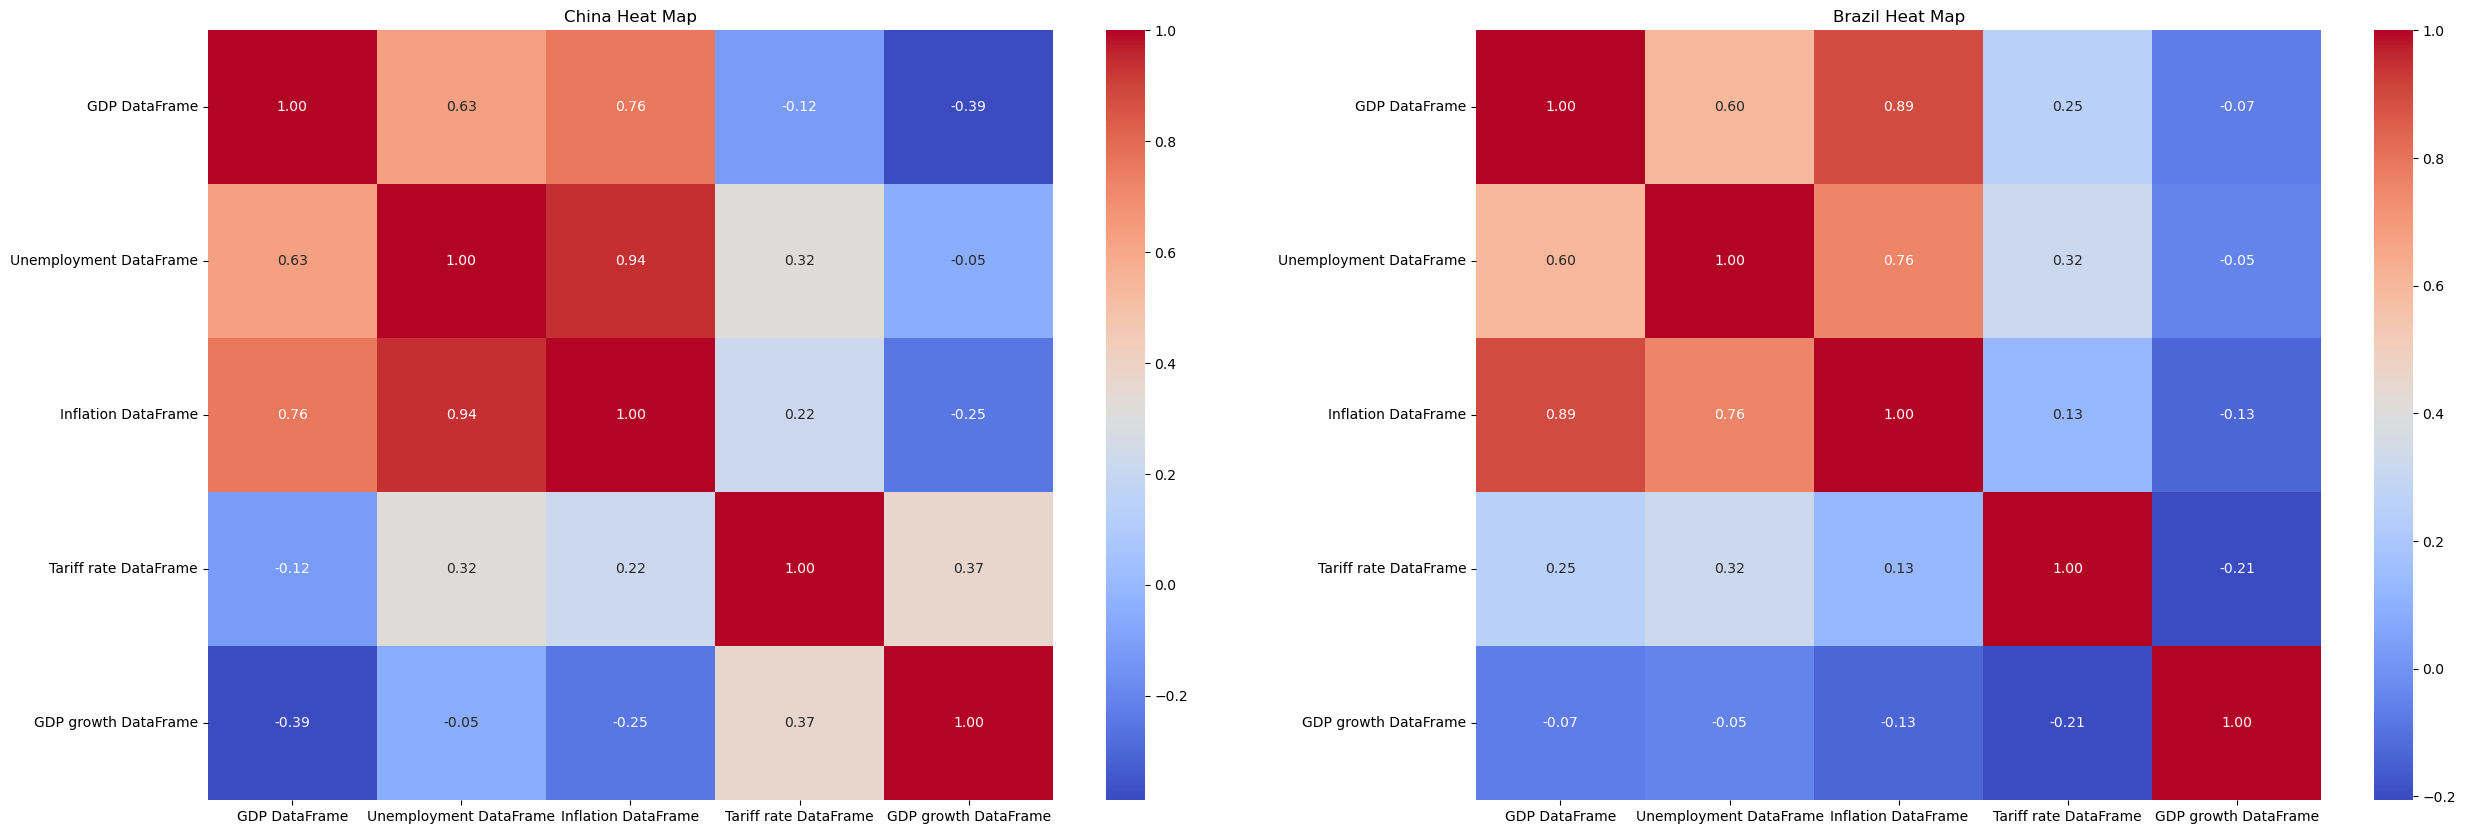

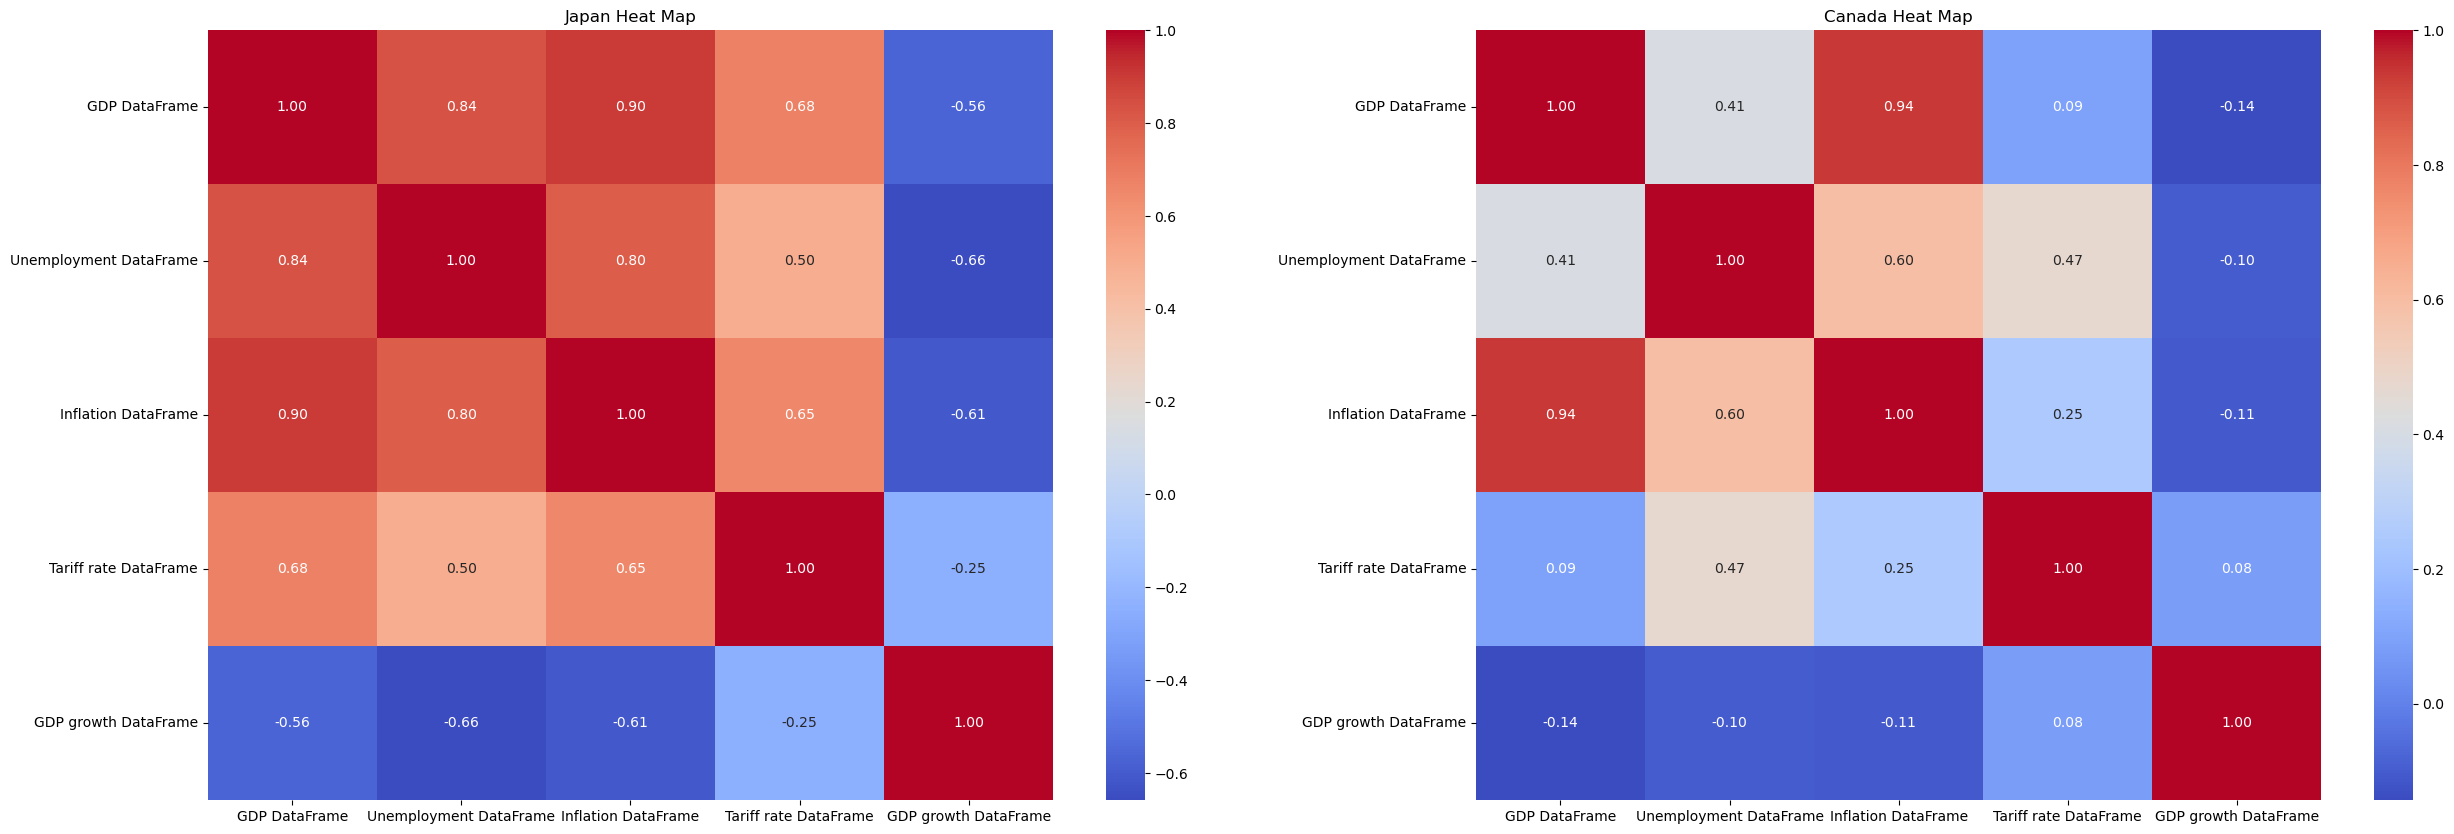

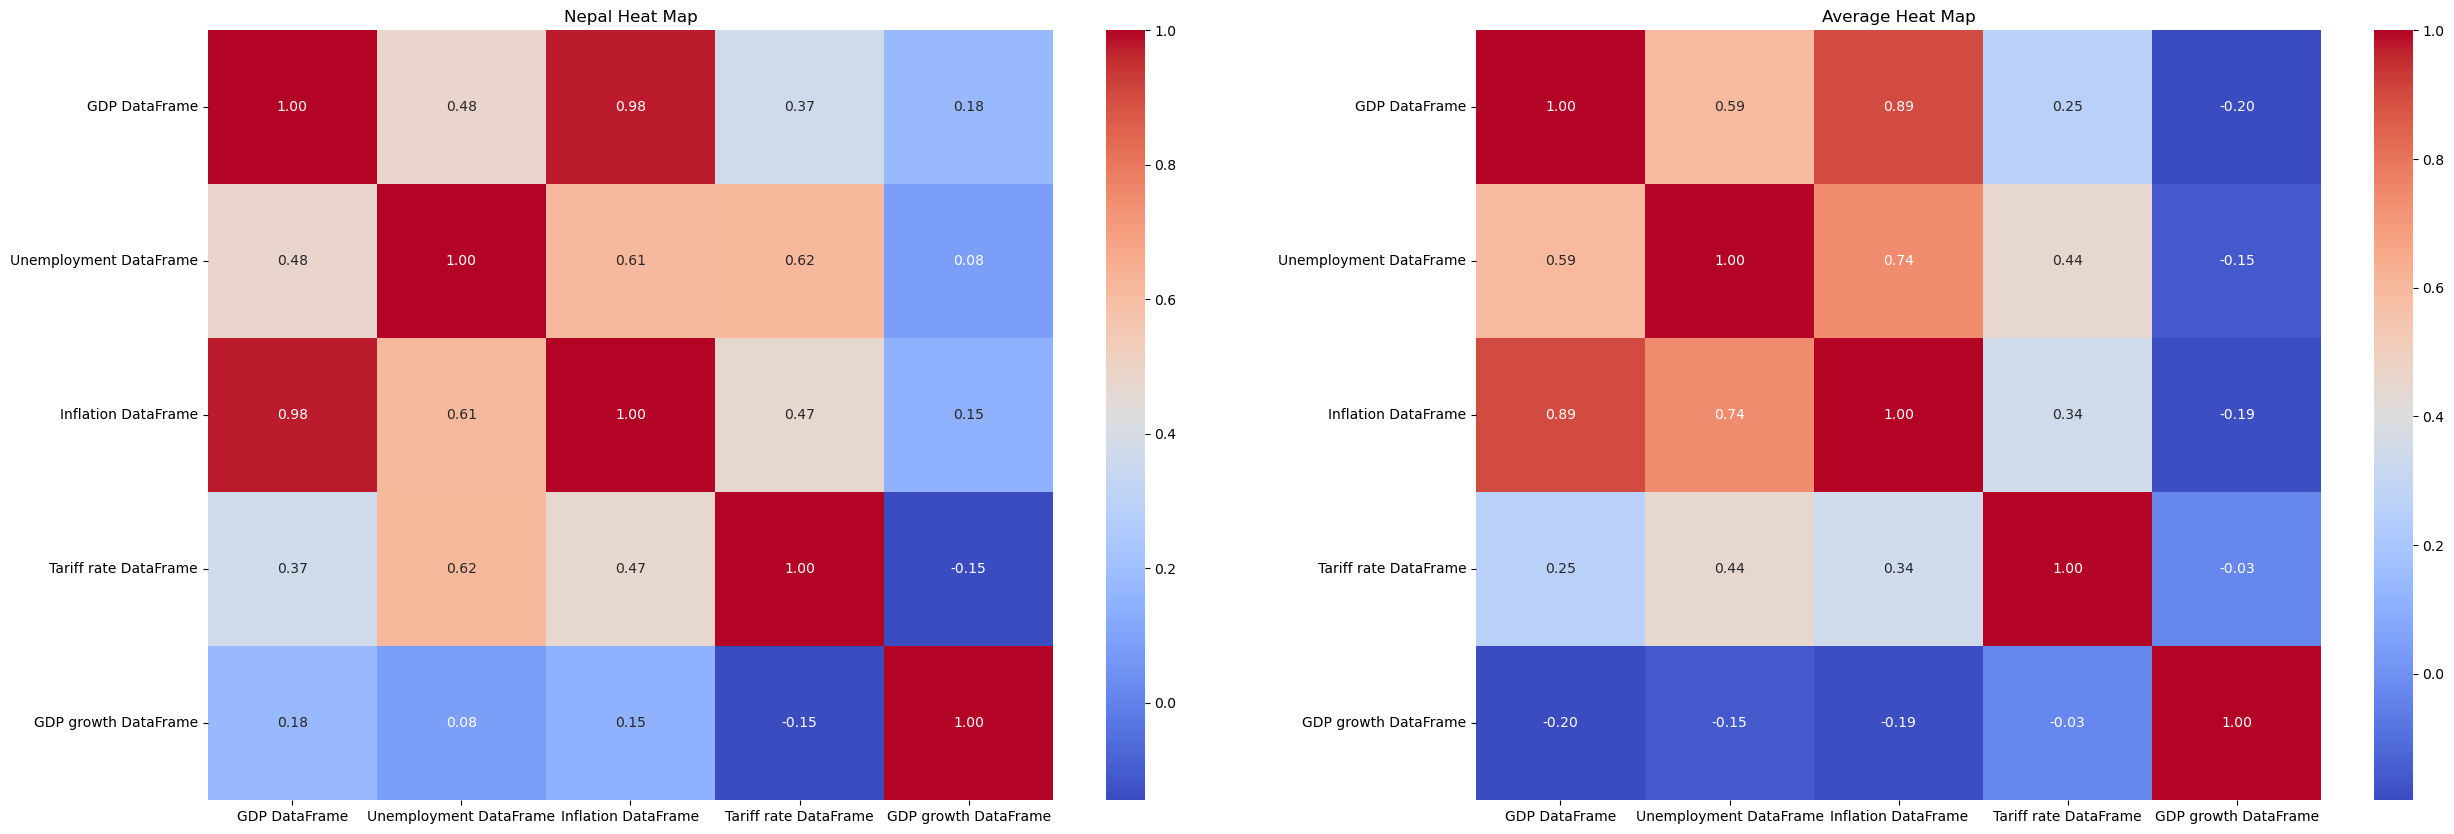

In [12]:
# For each country, we use heatmap to visualize the relations between indicators

fig, axs = plt.subplots(1, 2, figsize=(30, 10)) 
sns.heatmap(df_corrs['China'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f")
axs[0].set_title(f'China Heat Map')

sns.heatmap(df_corrs['Brazil'], ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f")
axs[1].set_title(f'Brazil Heat Map')

fig, axs = plt.subplots(1, 2, figsize=(30, 10)) 
sns.heatmap(df_corrs['Japan'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f")
axs[0].set_title(f'Japan Heat Map')

sns.heatmap(df_corrs['Canada'], ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f")
axs[1].set_title(f'Canada Heat Map')

fig, axs = plt.subplots(1, 2, figsize=(30, 10)) 
sns.heatmap(df_corrs['Nepal'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f")
axs[0].set_title(f'Nepal Heat Map')

# Inorder to identify the total thrend, we calculate the average value of all the correlation matrix, and show it in one chart
mean_corr_matrix = pd.DataFrame(np.mean([df_corr.values for df_corr in df_corrs.values()], axis=0)) # calculate mean here
mean_corr_matrix.index = dfs.keys()
mean_corr_matrix.columns = dfs.keys()
sns.heatmap(mean_corr_matrix, ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f")
axs[1].set_title(f'Average Heat Map')


plt.show()

In [13]:
# 各国的indicator之间的相关性差异没有特别大，他们都反应了相同的趋势
# 因此我们可以直接观察平均的heatmap
# 观察发现了几个重要的点
# 一是GDP的总量与通胀水平密切相关，这也揭示了GDP不直接反应一个国家的繁荣程度
# 同时，高失业率也与通胀水平密切相关，这有可能是在国家经济状态不好时高失业与高通胀的同时发生
# 有一个很蹊跷的地方是，高失业与GDP总量有着0.6左右的相关性，这意味着失业越多GDP越高，这点难以解释
# 另一点是关税与失业率有一定的正相关，这点有可能是国内经济状态下行导致失业率上升同时关税增加

- Creating box plots for the GDP growth rates of different countries allows for a quick visual comparison of their economic performance. Box plots summarize key statistics like the median, quartiles, and outliers, making it easy to identify trends, variability, and unusual data points across countries. It simplifies complex data, helping to highlight differences and similarities in GDP growth rates effectively.

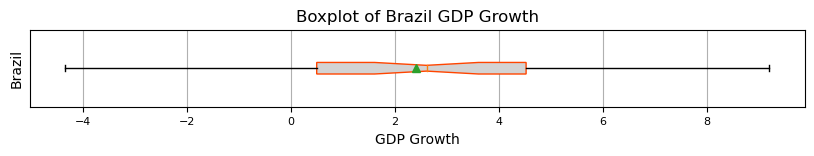

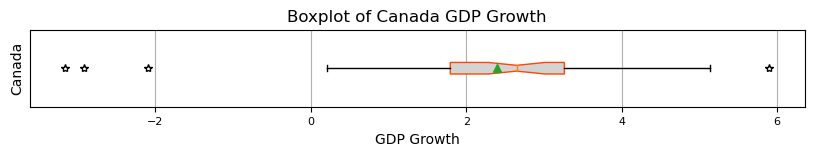

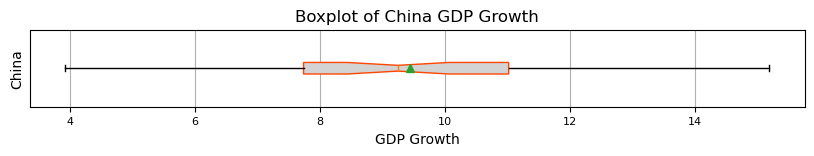

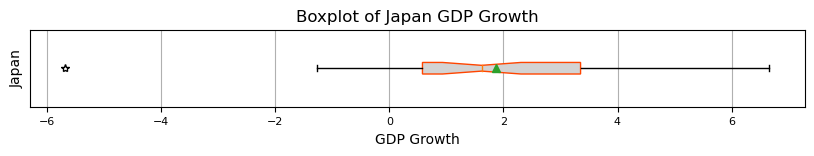

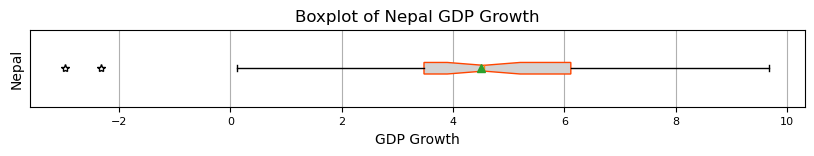

In [14]:
import matplotlib.pyplot as plt

# 循环遍历 gdp_growth_df 的每一列
for column in gdp_growth_df.columns:
    # 创建箱线图
    plt.figure(figsize=(10, 1))  # 设置图形大小
    plt.boxplot(gdp_growth_df[column], notch=True, sym='*', vert=False, showmeans=True, patch_artist=True,
                boxprops={'color': 'orangered', 'facecolor': 'lightgray'})  # 设置背景颜色更暗一些
    plt.xlabel('GDP Growth')  # 设置 x 轴标签
    plt.ylabel(column)  # 设置 y 轴标签为当前列名
    plt.title(f'Boxplot of {column} GDP Growth')
    plt.xticks(fontsize=8)
    plt.yticks(ticks=[], labels=[])
    plt.grid(axis='x')
    plt.show()

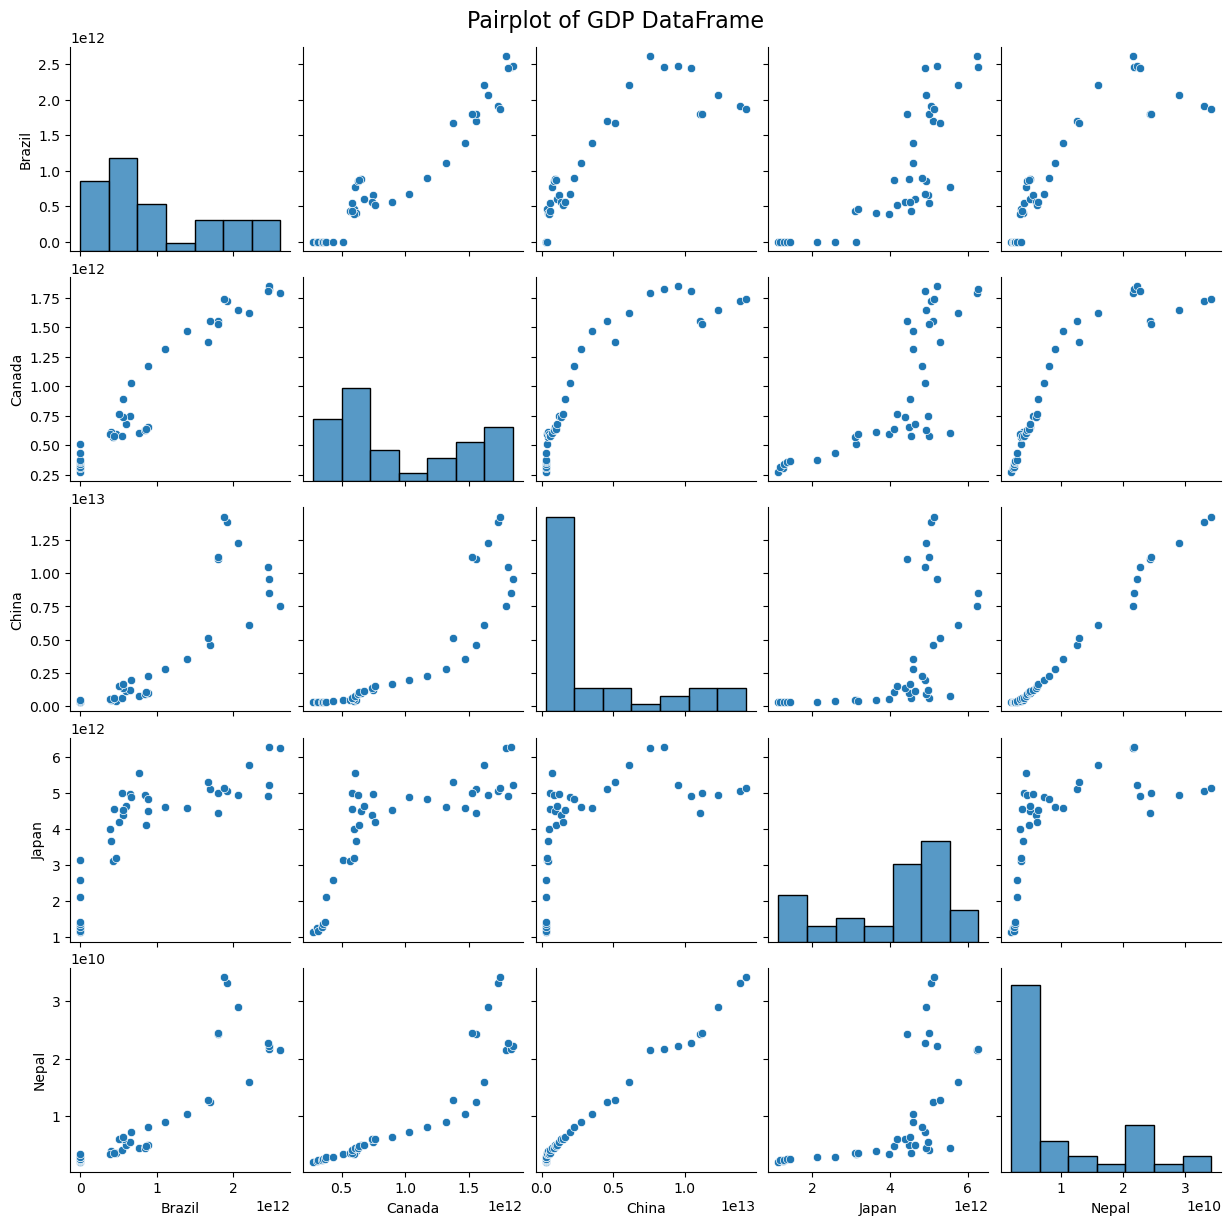

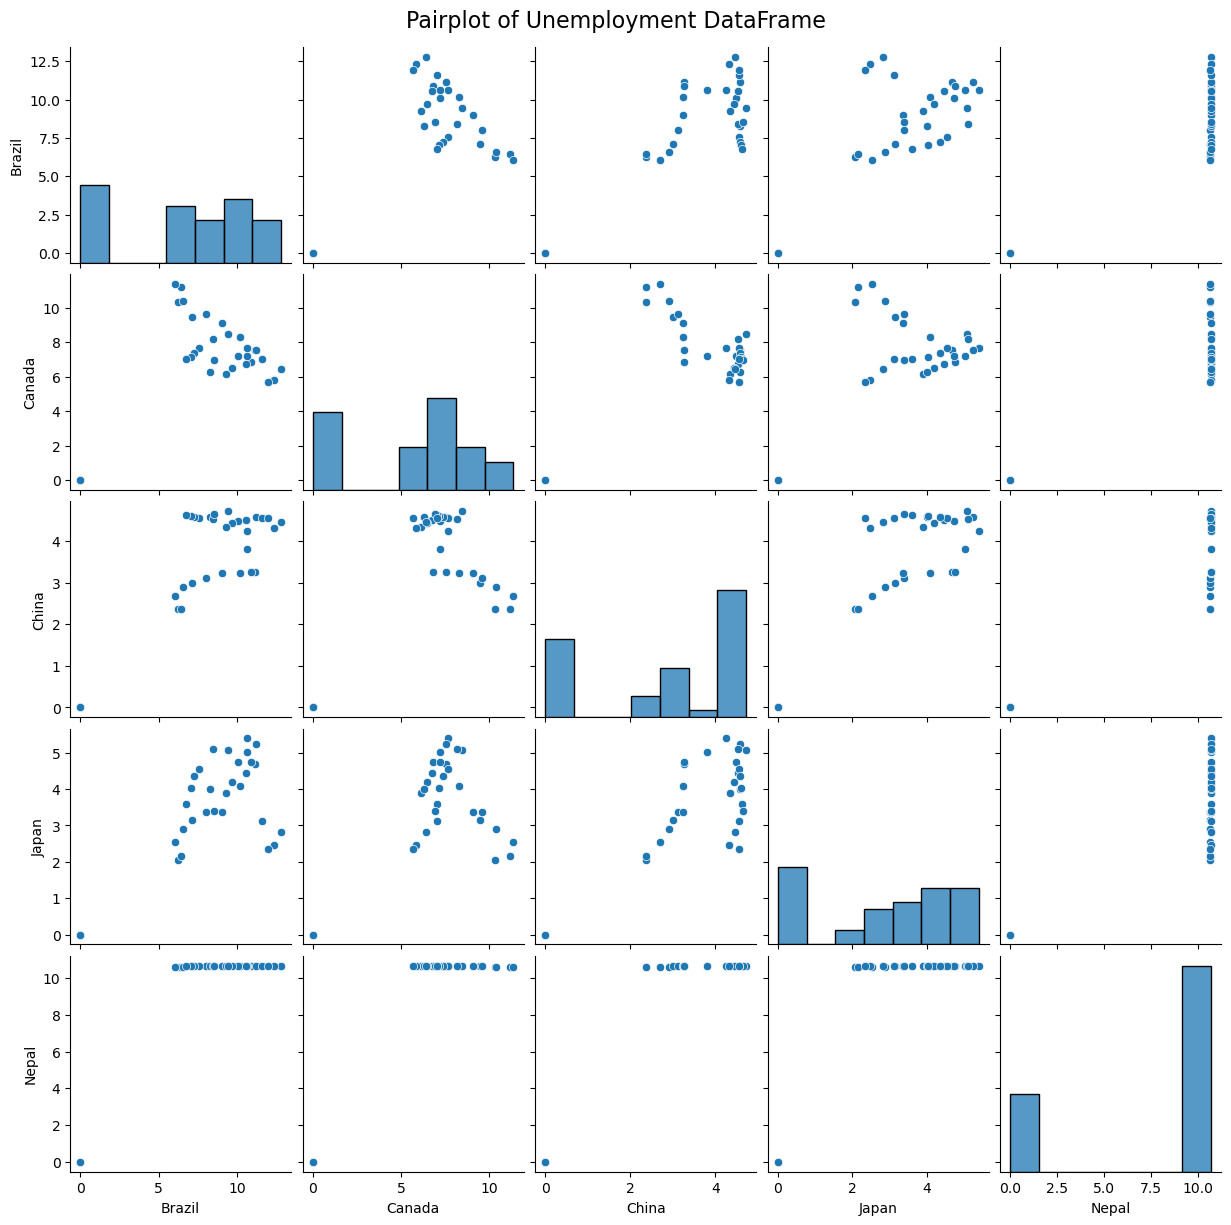

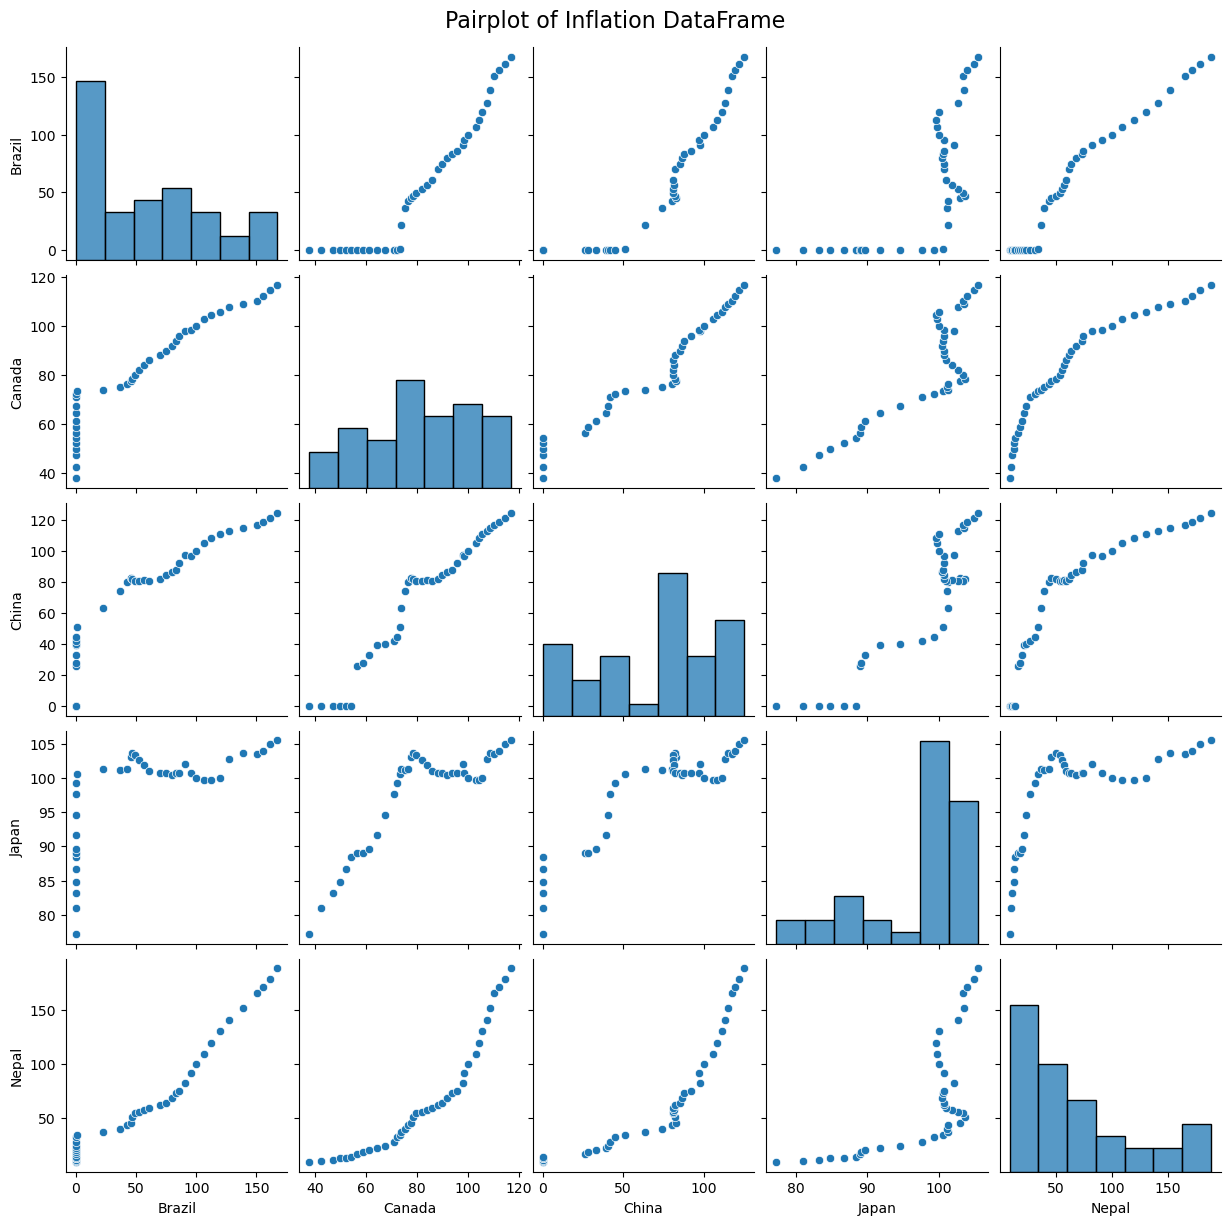

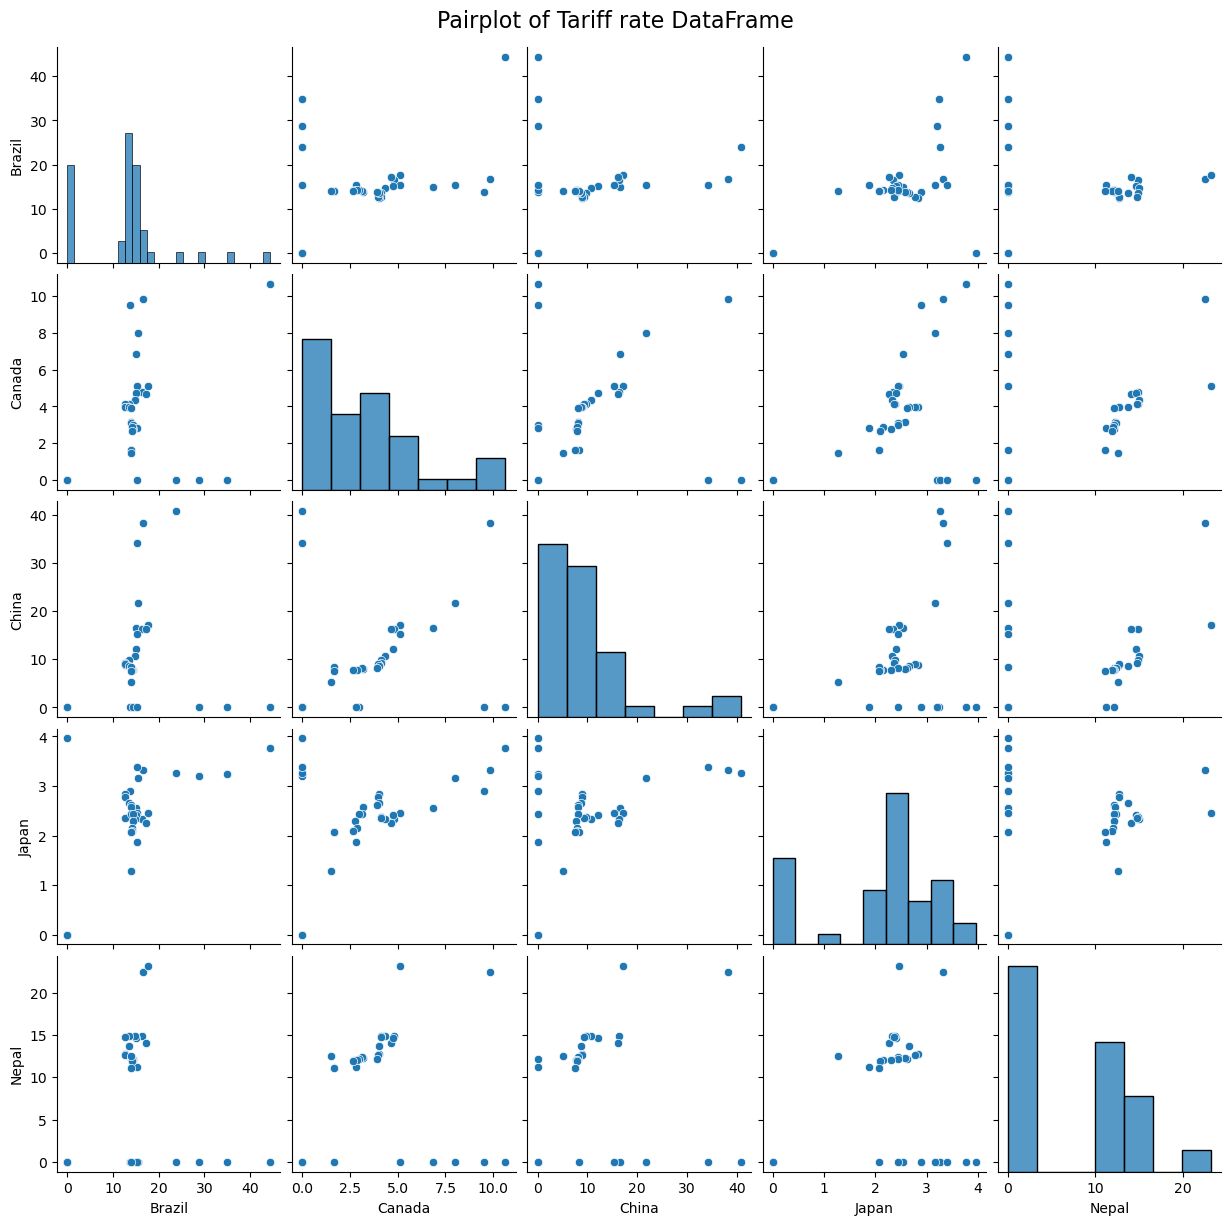

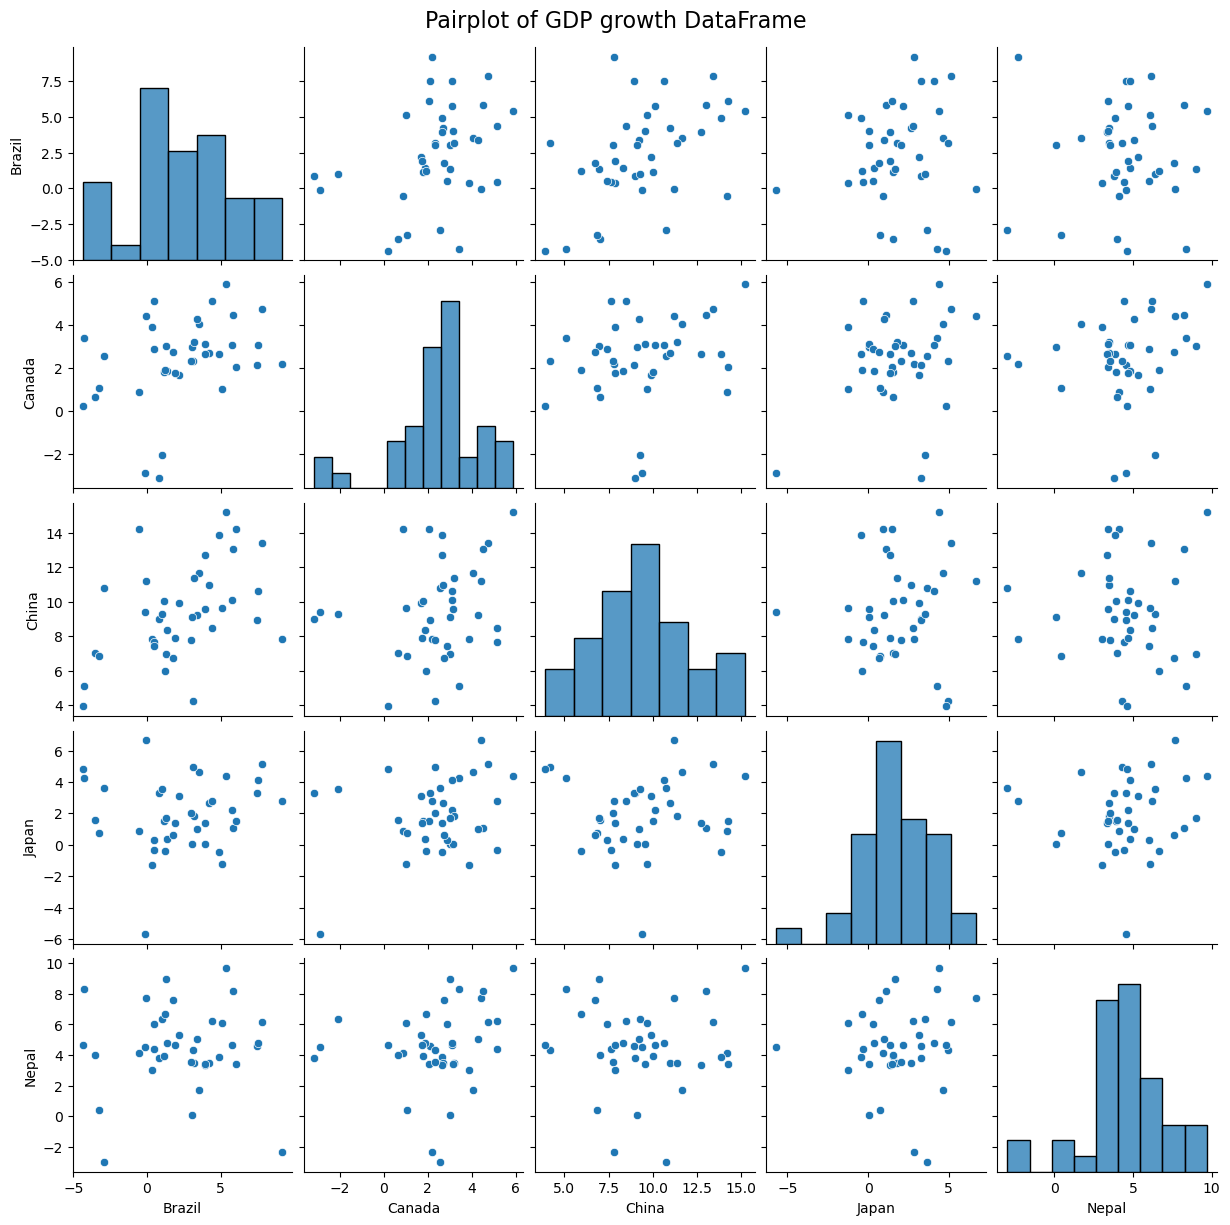

In [15]:
# We use pairplot in seaborn here to show how much is different country influencing each other on a certain indicator 
for (name, df) in dfs.items():
    pairplot = sns.pairplot(df)

    plt.subplots_adjust(top=0.95)
    pairplot.fig.suptitle(f'Pairplot of {name}', fontsize=16)

    plt.show()

In [16]:
# 通过上面几个表我们可以观察到，国家之间在大部分的指标上都没有表现出相关性
# 但是有两个指标表现出了强的正相关性，一个是GDP，另一个是关税
# GDP的正相关性在一定程度上可以反应国家之间的协同关系以及贸易往来，拿中国举例，中国与尼泊尔的GDP表现出强烈的正相关性，这表明了两国之间的贸易往来较为频繁，或者是两国都处在快速增长时期
# 在关税水平上，大部分国家都表现出了正相关，这很大程度上反应了世界的经济趋势以及环境

### Interpretation 
- Interpret the visualizations to draw meaningful conclusions about the 
economic health of the countries. 
- Discuss any correlations or anomalies found between different 
economic indicators.